<a href="https://colab.research.google.com/github/ikp-773/MRI-PD-Detection/blob/k-fold/K_Fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator


In [2]:
from google.colab import drive
drive.mount('/content/drive')
     

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/sliced_mri_dataset'

X = []
y = []

img_size=(256, 256)

for label, folder_name in enumerate(['control', 'parkinson']):
    folder_path = os.path.join(data_dir, folder_name)
    for subject in os.listdir(folder_path):
        subject_path = os.path.join(folder_path, subject)
        slices = []
        for img_name in sorted(os.listdir(subject_path)):
            img_path = os.path.join(subject_path, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size, color_mode='grayscale')
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            slices.append(img_array)
        slices = np.stack(slices, axis=0)
        X.append(slices)
        y.append(label)

X = np.array(X)
y = np.array(y)

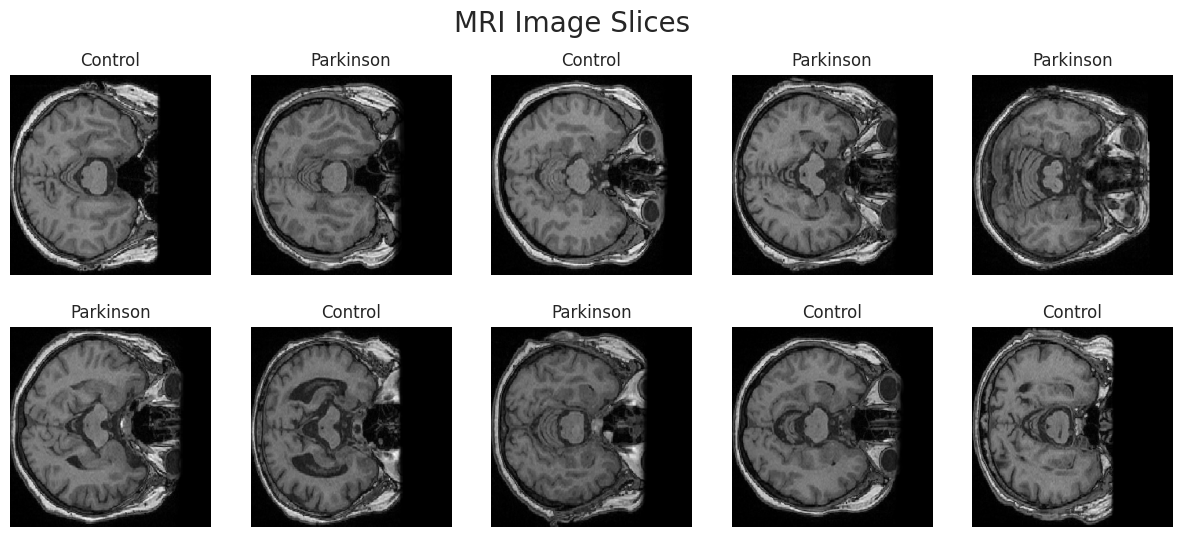

In [9]:

import seaborn as sns

sns.set_style("white")

def visualize_random_slices(X, y, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    fig.suptitle('MRI Image Slices', fontsize=20)
    for i in range(rows):
        for j in range(cols):
            index = np.random.randint(len(X))
            slice_index = np.random.randint(X.shape[1])
            axes[i, j].imshow(X[index, slice_index, :, :, 0], cmap='gray')
            axes[i, j].set_title('Control' if y[index] == 0 else 'Parkinson')
            axes[i, j].axis('off')
    plt.show()

visualize_random_slices(X, y)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [7]:
# class MRI_DataGenerator(tf.keras.utils.Sequence):
#     'Generates data for Keras'
#     def __init__(self, list_IDs, labels, batch_size=1, dim=(256,256), n_channels=1, n_slices=5, shuffle=True):
#         'Initialization'
#         self.dim = dim
#         self.batch_size = batch_size
#         self.labels = labels
#         self.list_IDs = list_IDs
#         self.n_channels = n_channels
#         self.n_slices = n_slices
#         self.shuffle = shuffle
#         self.on_epoch_end()

#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

#     def __data_generation(self, list_IDs_temp):
#         'Generates data containing batch_size samples'
#         X = np.empty((self.batch_size, self.n_slices, *self.dim, self.n_channels))
#         y = np.empty((self.batch_size), dtype=int)

#         # Generate data
#         for i, ID in enumerate(list_IDs_temp):
#             # Store sample
#             X[i,] = np.load('data/' + ID + '.npy')  # adjust this to match how your images are stored

#             # Store class
#             y[i] = self.labels[ID]

#         return X, y

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return int(np.floor(len(self.list_IDs) / self.batch_size))

#     def __getitem__(self, index):
#         'Generate one batch of data'
#         indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

#         # Find list of IDs
#         list_IDs_temp = [self.list_IDs[k] for k in indexes]

#         # Generate data
#         X, y = self.__data_generation(list_IDs_temp)

#         return X, y


In [8]:
# # Parameters
# params = {'dim': (256,256),
#           'batch_size': 64,
#           'n_channels': 1,
#           'n_slices': 5,
#           'shuffle': True}

# # Datasets
# partition = # IDs
# labels = # Labels

# # Generators
# training_generator = MRI_DataGenerator(partition['train'], labels, **params)
# validation_generator = MRI_DataGenerator(partition['validation'], labels, **params)


SyntaxError: ignored

# **Convolutional 3D Model**

In [10]:
input_shape = X_train.shape[1:]

print(input_shape)

model = Sequential()

model.add(Conv3D(32, kernel_size=(2, 2, 2), activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=(1, 2, 3)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(64, kernel_size=(2, 2, 2), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
     

(5, 256, 256, 1)


In [11]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 4, 255, 255, 32)   288       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 127, 85, 32)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 4, 127, 85, 32)   128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 4, 127, 85, 32)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 3, 126, 84, 64)    16448     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 3, 63, 42, 64)    0

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train, batch_size=4, validation_data=(X_test, y_test), epochs=32, callbacks=[early_stopping])


Epoch 1/32
9/9 [==============================] - 81s 9s/step - loss: 11.9447 - accuracy: 0.5294 - val_loss: 0.6333 - val_accuracy: 0.6667
Epoch 2/32
9/9 [==============================] - 72s 8s/step - loss: 6.1002 - accuracy: 0.5294 - val_loss: 0.6744 - val_accuracy: 0.6667
Epoch 3/32
9/9 [==============================] - 73s 8s/step - loss: 8.2831 - accuracy: 0.5000 - val_loss: 1.1827 - val_accuracy: 0.6667
Epoch 4/32
9/9 [==============================] - 72s 8s/step - loss: 25.6433 - accuracy: 0.4412 - val_loss: 0.7201 - val_accuracy: 0.6667
Epoch 5/32
9/9 [==============================] - 69s 8s/step - loss: 20.9349 - accuracy: 0.4706 - val_loss: 1.3468 - val_accuracy: 0.6667
Epoch 6/32
9/9 [==============================] - 69s 8s/step - loss: 13.7684 - accuracy: 0.4412 - val_loss: 3.4030 - val_accuracy: 0.6667


In [13]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", accuracy)

1/1 [==============================] - 3s 3s/step - loss: 3.4030 - accuracy: 0.6667
Test accuracy: 0.6666666865348816


In [14]:
model.save('/content/drive/MyDrive/conv3d_model')


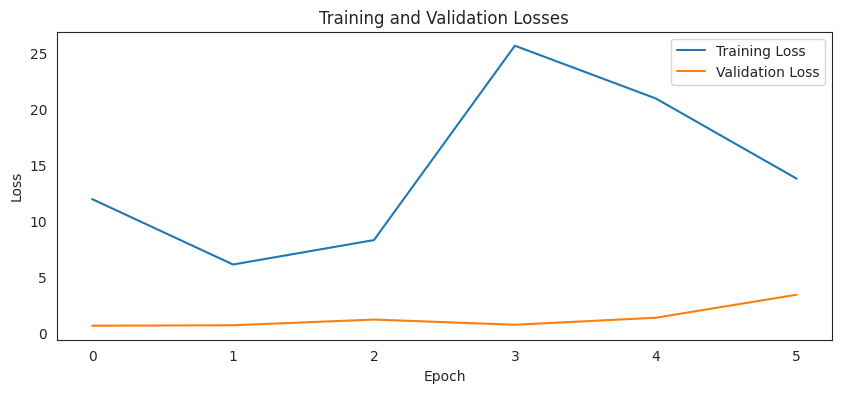

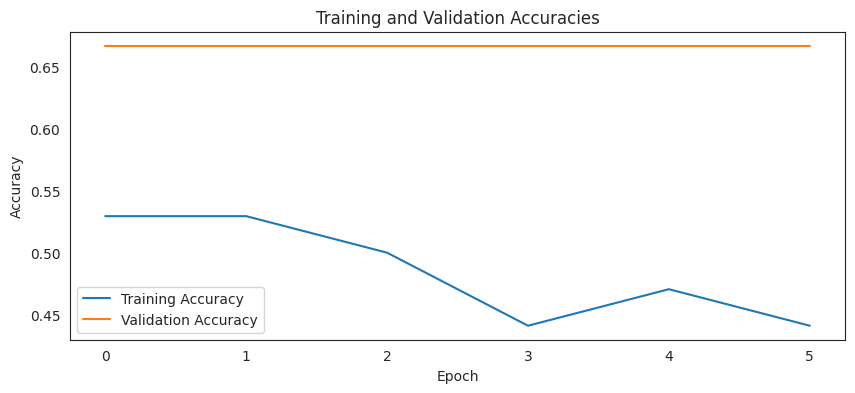

In [21]:
# training and validation loss
plt.figure(figsize=(10, 4))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# training and validation accuracy
plt.figure(figsize=(10, 4))

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [27]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)

print('Confusion matrix:')
print(cm)
print('Precision:', precision)
print('Recall:', recall)


1/1 [==============================] - 2s 2s/step


ValueError: ignored

# **Convolutional 3D Model with K-fold Validation**

In [16]:
from sklearn.model_selection import StratifiedKFold


In [17]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cvscores = []



In [28]:
fold_no = 1

for train, test in kfold.split(X, y):
    # create model
    model = Sequential()
    model.add(Conv3D(32, kernel_size=(2, 2, 2), activation='relu', input_shape=(5, 256, 256, 1)))
    model.add(MaxPooling3D(pool_size=(1, 2, 3)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Conv3D(64, kernel_size=(2, 2, 2), activation='relu'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Normalize the data
    X_train = X[train] / 255.0
    X_test = X[test] / 255.0

    early_stopping = EarlyStopping(monitor='val_loss', patience=3)


    # Fit the model
    model.fit(X_train, y[train], validation_data=(X_test, y[test]), epochs=16, batch_size=4, verbose=1, callbacks=[early_stopping])
    
    # Evaluate the model
    scores = model.evaluate(X_test, y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    cvscores.append(scores[1] * 100)
    fold_no += 1  


Epoch 1/16
9/9 [==============================] - 97s 8s/step - loss: 10.2278 - accuracy: 0.7353 - val_loss: 0.7315 - val_accuracy: 0.5556
Epoch 2/16
9/9 [==============================] - 68s 7s/step - loss: 22.6100 - accuracy: 0.5882 - val_loss: 2.8439 - val_accuracy: 0.5556
Epoch 3/16
9/9 [==============================] - 69s 8s/step - loss: 24.9270 - accuracy: 0.5000 - val_loss: 2.2003 - val_accuracy: 0.5556
Epoch 4/16
9/9 [==============================] - 65s 7s/step - loss: 14.0197 - accuracy: 0.5882 - val_loss: 4.2639 - val_accuracy: 0.5556
Score for fold 1: loss of 4.263941287994385; accuracy of 55.55555820465088%
Epoch 1/16
9/9 [==============================] - 69s 7s/step - loss: 9.6781 - accuracy: 0.4412 - val_loss: 0.6235 - val_accuracy: 0.6667
Epoch 2/16
9/9 [==============================] - 94s 11s/step - loss: 11.4134 - accuracy: 0.6471 - val_loss: 0.9703 - val_accuracy: 0.6667
Epoch 3/16
9/9 [==============================] - 67s 8s/step - loss: 13.6037 - accuracy: 

In [34]:
mean_accuracy = np.mean(cvscores)
std_dev_accuracy = np.std(cvscores)

print("accuracies")
print(cvscores)

print(f'Mean accuracy across folds: {mean_accuracy}')
print(f'Standard deviation of accuracy across folds: {std_dev_accuracy}')

accuracies
[55.55555820465088, 33.33333432674408, 66.66666865348816, 55.55555820465088, 33.33333432674408, 66.66666865348816, 62.5, 62.5]
Mean accuracy across folds: 54.51389029622078
Standard deviation of accuracy across folds: 12.856603295673116


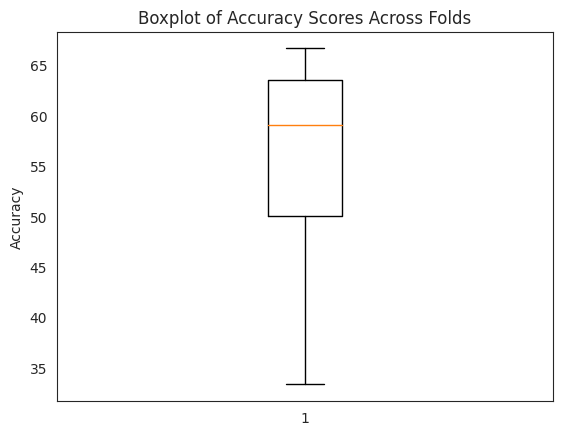

In [30]:
plt.boxplot(cvscores)
plt.title('Boxplot of Accuracy Scores Across Folds')
plt.ylabel('Accuracy')
plt.show()

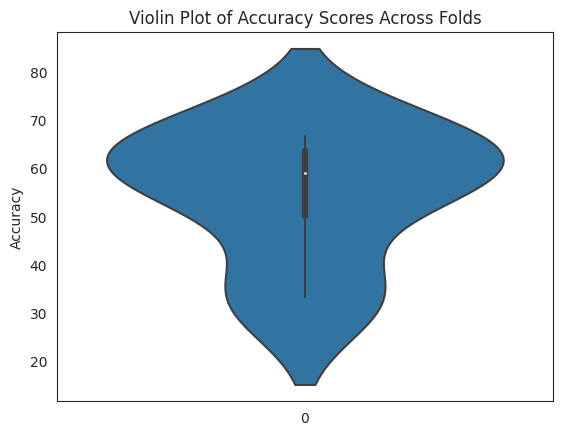

In [31]:
sns.violinplot(data=cvscores)
plt.title('Violin Plot of Accuracy Scores Across Folds')
plt.ylabel('Accuracy')
plt.show()

# **ResNet50V2 Pre-trained Model**

In [12]:
from keras.applications import ResNet50V2
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model


In [13]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)


ValueError: ignored

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Add your own classification layers on top of the pre-trained model
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(val_data, val_labels))


In [14]:
# Fine-tune the pre-trained layers
for layer in model.layers[:150]:
   layer.trainable = False
for layer in model.layers[150:]:
   layer.trainable = True


In [15]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])


NameError: ignored

In [16]:
model.fit(train_data, train_labels, epochs=20, batch_size=32, validation_data=(val_data, val_labels))


NameError: ignored